In [85]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score
from typing import Literal
from datetime import datetime
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from tqdm.auto import tqdm

os.chdir("../..")
from examples.help_modules import BigQuery, Logger, CStorage

In [ ]:
dataset = 'homes'
logger = Logger(f'train_pytorch_{dataset.capitalize()}')
bq = BigQuery(logger=logger,dataset=dataset)
cs = CStorage(logger=logger, bucket_name='sibr-market-bucket')
logger.debug(f'Dataset: {dataset}')

In [ ]:
data = bq.read_homes(task = "train")
df_a = data.get("homes_apartments")

In [36]:
def load_data(df,target: str, batch_size: int = 32,log_target = True,num_workers = os.cpu_count()) -> tuple:
    '''
    Load data into PyTorch DataLoader for training and testing.
    :param target:
    :return: tuple of DataLoaders and attributes:  (train_dataloader, test_dataloader,embedding_dims,n_continuous)
    '''

    X = df.drop(columns=[target], axis=1)
    y = np.log1p(df[target]) if log_target else df[target]
    for col in X:
        df[col] = df[col].astype(float)

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

    pipeline = Pipeline(steps = [
                                ('impute', SimpleImputer(strategy='median')),
                                ('scaler', StandardScaler())
                                ])

    X_train_sc, X_test_sc = pipeline.fit_transform(X_train),pipeline.transform(X_test)
    X_train_t,X_test_t = torch.from_numpy(X_train_sc).type(torch.float),torch.from_numpy(X_test_sc).type(torch.float)
    y_train_t, y_test_t = torch.from_numpy(y_train.to_numpy()).type(torch.float), torch.from_numpy(y_test.to_numpy()).type(torch.float)


    train_dataset = TensorDataset(X_train_t,y_train_t)
    test_dataset = TensorDataset(X_test_t,y_test_t)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                                  num_workers=num_workers)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                                 num_workers=num_workers)

    n_continuous = X_train_t.shape[1]
    logger.info(f'Train size: {len(train_dataloader.dataset)} | Test size: {len(test_dataset)} with {n_continuous} continuous features')
    return train_dataloader, test_dataloader,n_continuous

In [ ]:
def _train_model(train_loader, test_loader,hidden_dim = None,device = None,learning_rate = 0.001):
    """
    Trene det nevrale nettverket og returnere modellen sammen med resultater i en tuple.
    Resultater inkluderer treningsloss, valideringsloss og R²-score.
    """
    # Forbehandle data
    train_loader, test_loader = preprocess_data(train_loader, test_loader)

    train_starttime = datetime.now()
    device = ("mps" if torch.mps.is_available() else "cpu") if device is None else device
    input_dim = next(iter(train_loader))[0].shape[1]
    hidden_dim = 64 if hidden_dim is None else hidden_dim
    learning_rate = 0.001 if learning_rate is None else learning_rate
    model = RegressionNN(input_dim,hidden_dim=hidden_dim).to(device)
    print(f"training model with {input_dim} features and {hidden_dim} hidden dim on device {device}")

    # Definere tap-funksjon og optimizer
    criterion = nn.MSELoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    metric = r2_score

    # Treningsløkke
    num_epochs = 700
    best_loss = float('inf')
    min_delta = 0.001
    no_improve = 0
    patients = 20
    results = {'train_loss': [], 'val_loss': [], 'val_r2': [],'train_r2' : []}
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_preds_train = []
        all_targets_train = []
        for features, target in train_loader:
            features, target = features.to(device), target.to(device)
            optimizer.zero_grad()
            outputs = model(features)
            if len(target.shape) == 1:
                target = target.unsqueeze(1)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            all_preds_train.append(outputs)
            all_targets_train.append(target)


        # Validering
        model.eval()
        val_loss = 0.0
        all_preds_test = []
        all_targets_test = []
        with torch.no_grad():
            for features, target in test_loader:
                features, target = features.to(device), target.to(device)
                outputs = model(features)
                if len(target.shape) == 1:
                    target = target.unsqueeze(1)
                loss = criterion(outputs, target)
                val_loss += loss.item()
                all_preds_test.append(outputs)
                all_targets_test.append(target)

        # Beregn R²-score
        all_preds_test = torch.cat(all_preds_test, dim=0).cpu().numpy()
        all_targets_test = torch.cat(all_targets_test, dim=0).cpu().numpy()
        all_preds_train = torch.cat(all_preds_train, dim=0).detach().cpu().numpy()
        all_targets_train = torch.cat(all_targets_train, dim=0).detach().cpu().numpy()
        val_r2 = metric(all_targets_test, all_preds_test)
        train_r2 = metric(all_targets_train, all_preds_train)

        # Beregn gjennomsnittlig loss
        train_loss = running_loss / len(train_loader)
        val_loss_avg = val_loss / len(test_loader)

        if best_loss - min_delta > val_loss_avg:
            best_loss = val_loss_avg
        else:
            no_improve += 1

        if no_improve >= patients:
            print(f"No improvement of {patients} epochs, stopping training after time {str(datetime.now() - train_starttime)}.")
            break

        # Skriv ut fremgang
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss_avg:.4f}, Val R² test: {val_r2:.4f}, Val R² test: {train_r2:.4f} | time elapsed: {datetime.now() - train_starttime}')

        # Lagre resultater
        results['train_loss'].append(train_loss)
        results['val_loss'].append(val_loss_avg)
        results['train_r2'].append(train_r2)
        results['val_r2'].append(val_r2)
        results["time_elapsed"] = datetime.now() - train_starttime
    print(f"finished training in {datetime.now() - train_starttime}")
    return model, results

In [37]:
def plot_loss_curves(results):
    loss = results['train_loss']
    test_loss = results['val_loss']
    r2 = results['train_r2']
    test_r2 = results['val_r2']
    epochs = range(len(results['train_loss']))
    plt.figure(figsize = (16,8))

    plt.subplot(1,2,1)
    plt.plot(epochs,loss,label = 'Train loss')
    plt.plot(epochs,test_loss,label = 'Test loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs,r2,label = 'Train r2')
    plt.plot(epochs,test_r2,label = 'Test r2')
    plt.title('R2 Score')
    plt.xlabel('Epochs')
    plt.legend()

In [62]:
def preprocess_data(train_loader, test_loader):
    """
    Forbehandle data fra dataloaderne: imputer manglende verdier og skaler funksjoner.
    Returnerer nye dataloadere med forbehandlede data.
    """
    # Samle all treningsdata
    train_data = []
    train_targets = []
    for batch in train_loader:
        features, target = batch
        train_data.append(features)
        train_targets.append(target)
    train_data = torch.cat(train_data, dim=0)
    train_targets = torch.cat(train_targets, dim=0)

    # Samle all testdata
    test_data = []
    test_targets = []
    for batch in test_loader:
        features, target = batch
        test_data.append(features)
        test_targets.append(target)
    test_data = torch.cat(test_data, dim=0)
    test_targets = torch.cat(test_targets, dim=0)

    # Håndter manglende verdier med median fra treningsdata
    medians = torch.nanmedian(train_data, dim=0).values
    imputed_train_data = torch.where(torch.isnan(train_data), medians, train_data)
    imputed_test_data = torch.where(torch.isnan(test_data), medians, test_data)

    # Skaler funksjoner med gjennomsnitt og standardavvik fra treningsdata
    means = imputed_train_data.mean(dim=0)
    stds = imputed_train_data.std(dim=0)
    stds = torch.where(stds == 0, torch.ones_like(stds), stds)
    scaled_train_data = (imputed_train_data - means) / stds
    scaled_test_data = (imputed_test_data - means) / stds

    # Lag nye datasets og dataloadere
    train_dataset = TensorDataset(scaled_train_data, train_targets)
    test_dataset = TensorDataset(scaled_test_data, test_targets)
    new_train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    new_test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    return new_train_loader, new_test_loader

In [64]:
class RegressionNN(nn.Module):
    def __init__(self, input_dim,hidden_dim = 64,dropout = 0.2):
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [88]:
class RegressionNN_V2(nn.Module):
    def __init__(self, input_dim, hidden_dim=2048, dropout=0.1):
        super(RegressionNN_V2, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc1a = nn.Linear(hidden_dim, hidden_dim)
        self.bn1a = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.bn2 = nn.BatchNorm1d(hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn1a(self.fc1a(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [91]:
def train_model(model_type : torch.nn.Module,
                train_loader : torch.utils.data.DataLoader,
                test_loader : torch.utils.data.DataLoader,
                hidden_dim : int =None,
                device : str =None,
                learning_rate : float =0.001,
                min_delta : float =0.001,
                patients : int =20,
                epochs : int  = 700,
                dropout : float  = 0.2,
                log_target : bool =False,
                loss_function : str = Literal["mse", "mae", "smooth"],):
    """
    Trene det nevrale nettverket og returnere modellen sammen med resultater i en tuple.
    Resultater inkluderer treningsloss, valideringsloss og R²-score.
    Hvis log_target=True, antas target å være log-transformert, og metrics beregnes på originalskala.
    """
    # Forbehandle data
    starttime = datetime.now()
    train_loader, test_loader = preprocess_data(train_loader, test_loader)

    train_starttime = datetime.now()
    device = ("mps" if torch.backends.mps.is_available() else "cpu") if device is None else device
    input_dim = next(iter(train_loader))[0].shape[1]
    hidden_dim = 64 if hidden_dim is None else hidden_dim
    learning_rate = 0.001 if learning_rate is None else learning_rate
    model = model_type(input_dim, hidden_dim=hidden_dim,dropout=dropout).to(device)

    if not loss_function or loss_function == "mse":
        loss_function = nn.MSELoss()
    elif loss_function == "mae":
        loss_function = nn.L1Loss()
    elif loss_function == "smooth":
        loss_function = nn.SmoothL1Loss()
    else:
        raise ValueError(f'Loss function "{loss_function}" not recognized.')
    criterion = loss_function.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)  # Lagt til vektforfall

    # Treningsløkke
    num_epochs = epochs
    best_loss = float('inf')
    min_delta = min_delta
    no_improve = 0
    patients = patients
    results = {'train_loss': [], 'val_loss': [], 'val_r2': [], 'train_r2': []}
    model_info = {
        'model_type': model_type.__class__.__name__,
        'input_dim': input_dim,
        'hidden_dim': hidden_dim,
        'criterion': str(criterion),
        'optimizer': str(optimizer),
        'metric': 'r2_score',
        'device': device,
        'log_target': log_target,
        'learning_rate': learning_rate,
        'patients': patients,
        'min_delta': min_delta,
        'num_epochs': num_epochs,
    }
    print(f"Training model with the following specification:")
    for key, value in model_info.items():
        print(f"{key}: {value}")

    for epoch in tqdm(range(num_epochs)):
        model.train()
        running_loss = 0.0
        all_preds_train = []
        all_targets_train = []
        for features, target in train_loader:
            features, target = features.to(device), target.to(device)
            optimizer.zero_grad()
            outputs = model(features)
            if len(target.shape) == 1:
                target = target.unsqueeze(1)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            all_preds_train.append(outputs.detach().cpu().numpy().astype(np.float64))  # Konverter til float64
            all_targets_train.append(target.detach().cpu().numpy().astype(np.float64))

        # Validering
        model.eval()
        val_loss = 0.0
        all_preds_test = []
        all_targets_test = []
        with torch.no_grad():
            for features, target in test_loader:
                features, target = features.to(device), target.to(device)
                outputs = model(features)
                if len(target.shape) == 1:
                    target = target.unsqueeze(1)
                loss = criterion(outputs, target)
                val_loss += loss.item()
                all_preds_test.append(outputs.detach().cpu().numpy().astype(np.float64))
                all_targets_test.append(target.detach().cpu().numpy().astype(np.float64))

        # Samle alle prediksjoner og targets
        all_preds_test = np.concatenate(all_preds_test, axis=0)
        all_targets_test = np.concatenate(all_targets_test, axis=0)
        all_preds_train = np.concatenate(all_preds_train, axis=0)
        all_targets_train = np.concatenate(all_targets_train, axis=0)

        # Hvis log_target=True, clippe og transformer tilbake til originalskala for metrics
        if log_target:
            # Clippe for å unngå overflow (maks log-verdi ~88 for float32)
            all_preds_test = np.clip(all_preds_test, -100, 88)
            all_targets_test = np.clip(all_targets_test, -100, 88)
            all_preds_train = np.clip(all_preds_train, -100, 88)
            all_targets_train = np.clip(all_targets_train, -100, 88)
            all_preds_test = np.expm1(all_preds_test)
            all_targets_test = np.expm1(all_targets_test)
            all_preds_train = np.expm1(all_preds_train)
            all_targets_train = np.expm1(all_targets_train)

        # Beregn R²-score på originalskala
        val_r2 = r2_score(all_targets_test, all_preds_test)
        train_r2 = r2_score(all_targets_train, all_preds_train)

        # Beregn gjennomsnittlig loss (på den skalaen modellen er trent på)
        train_loss = running_loss / len(train_loader)
        val_loss_avg = val_loss / len(test_loader)

        # Early stopping sjekk
        if best_loss - min_delta > val_loss_avg:
            best_loss = val_loss_avg
            no_improve = 0
        else:
            no_improve += 1

        if no_improve >= patients:
            print(f"No improvement of {patients} epochs, stopping training after time {str(datetime.now() - train_starttime)}.")
            return model.state_dict(), results, model_info

        # Skriv ut fremgang
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss_avg:.4f}, Val R²: {val_r2:.4f}, Train R²: {train_r2:.4f} | time elapsed: {datetime.now() - train_starttime}')

        # Lagre resultater
        results['train_loss'].append(train_loss)
        results['val_loss'].append(val_loss_avg)
        results['val_r2'].append(val_r2)
        results['train_r2'].append(train_r2)
        results["time_elapsed"] = datetime.now() - train_starttime

    print(f"Finished training in {datetime.now() - train_starttime}")
    return model.state_dict(), results, model_info

In [67]:
log_target = False
train,test,n_continuous = load_data(df = df_a,
                                    target = "price",
                                    batch_size = 32,
                                    log_target = log_target,
                                    num_workers = os.cpu_count())
model_dict,res,model_info  = train_model(train,test,device="cpu",hidden_dim=256,learning_rate=0.1,log_target=log_target)

2025-08-04 15:58:04,782 - train_pytorch_Homes - INFO - Train size: 72155 | Test size: 18039 with 54 continuous features


In [95]:
log_target = False
batch_size = 1024
train,test,n_continuous = load_data(df = df_a,
                                    target = "price",
                                    batch_size = batch_size,
                                    log_target = log_target,
                                    num_workers = os.cpu_count())

model_dict,res, model_info  = train_model(model_type = RegressionNN_V2,
                                         train_loader=train,
                                         test_loader=test,
                                         device="mps",
                                         hidden_dim=batch_size * 2,
                                         learning_rate=0.005,
                                         dropout=0.05,
                                         log_target=log_target,
                                         min_delta=500,
                                          loss_function="smooth"
                                         )

2025-08-04 17:03:12,679 - train_pytorch_Homes - INFO - Train size: 72155 | Test size: 18039 with 54 continuous features


Training model with the following specification:
model_type: type
input_dim: 54
hidden_dim: 2048
criterion: SmoothL1Loss()
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 1e-05
)
metric: r2_score
device: mps
log_target: False
learning_rate: 0.01
patients: 20
min_delta: 500
num_epochs: 700


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 1, Train Loss: 3966048.1620, Val Loss: 3099634.4116, Val R²: -1.1436, Train R²: -1.9217 | time elapsed: 0:00:23.560415
Epoch 2, Train Loss: 1831155.4374, Val Loss: 750675.0612, Val R²: 0.7525, Train R²: -0.0706 | time elapsed: 0:00:46.656347
Epoch 3, Train Loss: 759485.2406, Val Loss: 572488.2601, Val R²: 0.8700, Train R²: 0.7702 | time elapsed: 0:01:09.397017
Epoch 4, Train Loss: 711762.9287, Val Loss: 567604.5034, Val R²: 0.8805, Train R²: 0.8056 | time elapsed: 0:01:32.219739
Epoch 5, Train Loss: 695890.2741, Val Loss: 567751.2615, Val R²: 0.8676, Train R²: 0.8131 | time elapsed: 0:01:54.790048
Epoch 6, Train Loss: 676026.9424, Val Loss: 550707.6362, Val R²: 0.8653, Train R²: 0.8251 | time elapsed: 0:02:17.656122
Epoch 7, Train Loss: 664795.8089, Val Loss: 552610.0668, Val R²: 0.8768, Train R²: 0.8303 | time elapsed: 0:02:40.474124
Epoch 8, Train Loss: 660691.6212, Val Loss: 534759.2274, Val R²: 0.8870, Train R²: 0.8323 | time elapsed: 0:03:02.841080
Epoch 9, Train Loss: 65497

In [97]:
log_target = True
batch_size = 1024
train,test,n_continuous = load_data(df = df_a,
                                    target = "price",
                                    batch_size = batch_size,
                                    log_target = log_target,
                                    num_workers = os.cpu_count())

model_dict,res, model_info  = train_model(model_type = RegressionNN_V2,
                                         train_loader=train,
                                         test_loader=test,
                                         device="mps",
                                         hidden_dim=batch_size*2,
                                         learning_rate=0.001,
                                         dropout=0.3,
                                         log_target=log_target,
                                         min_delta=0.001,
                                          loss_function="mse"
                                         )

2025-08-04 20:47:56,188 - train_pytorch_Homes - INFO - Train size: 72155 | Test size: 18039 with 54 continuous features


Training model with the following specification:
model_type: type
input_dim: 54
hidden_dim: 2048
criterion: MSELoss()
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 1e-05
)
metric: r2_score
device: mps
log_target: True
learning_rate: 0.001
patients: 20
min_delta: 0.001
num_epochs: 700


  0%|          | 0/700 [00:00<?, ?it/s]

Epoch 1, Train Loss: 2.0635, Val Loss: 0.3957, Val R²: -21420871.8058, Train R²: -14.9976 | time elapsed: 0:00:23.923928
Epoch 2, Train Loss: 0.4778, Val Loss: 0.1528, Val R²: -138.5936, Train R²: -2.5027 | time elapsed: 0:00:46.311942
Epoch 3, Train Loss: 0.3910, Val Loss: 0.1973, Val R²: -502.0238, Train R²: -1.1906 | time elapsed: 0:01:08.668459
Epoch 4, Train Loss: 0.3524, Val Loss: 0.0984, Val R²: -107.7390, Train R²: -0.8711 | time elapsed: 0:01:30.893701
Epoch 5, Train Loss: 0.3202, Val Loss: 0.3769, Val R²: -2.1505, Train R²: -0.6843 | time elapsed: 0:01:53.210792
Epoch 6, Train Loss: 0.3051, Val Loss: 0.0980, Val R²: 0.5679, Train R²: -0.5352 | time elapsed: 0:02:15.587552
Epoch 7, Train Loss: 0.2817, Val Loss: 0.1562, Val R²: -9.2767, Train R²: -0.2857 | time elapsed: 0:02:37.101767
Epoch 8, Train Loss: 0.2700, Val Loss: 0.2784, Val R²: -0.1751, Train R²: -0.2568 | time elapsed: 0:02:58.733964
Epoch 9, Train Loss: 0.2567, Val Loss: 0.0893, Val R²: 0.6117, Train R²: -0.1329 | 

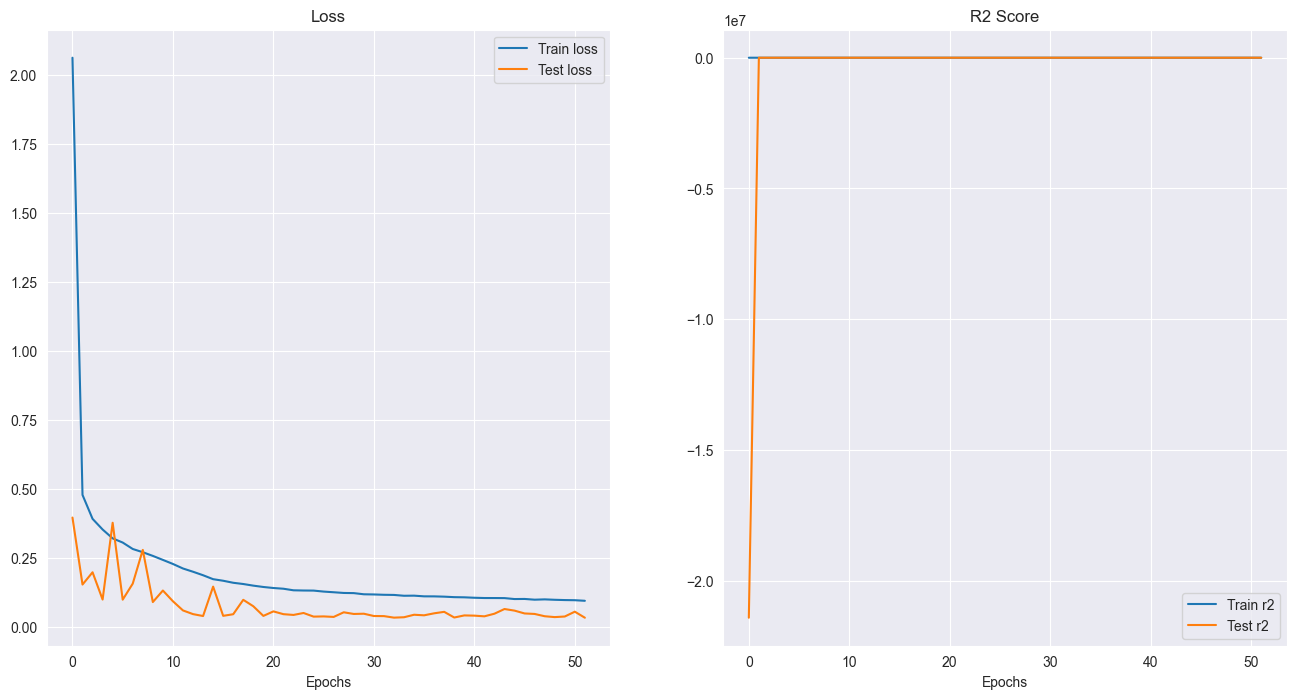

In [98]:
plot_loss_curves(res)